In [68]:
import numpy as np
import scipy as sci
import pandas as pd
import ipaddress
import re

from collections import defaultdict, Counter
from datetime import datetime, timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from bokeh.plotting import figure, show, output_notebook
from bokeh.charts import *
output_notebook()

from sqlalchemy import create_engine, text, func, or_, and_, not_, distinct
from sqlalchemy.orm import sessionmaker
from sqlalchemy.pool import NullPool

from model.Base import Base
from model.User import User
from model.Device import Device
from model.DeviceTraffic import DeviceTraffic
from model.DeviceAppTraffic import DeviceAppTraffic
from model.HttpReq import HttpReq
from model.DnsReq import DnsReq
from model.Location import Location
from model.user_devices import user_devices;

import datautils

DB='postgresql+psycopg2:///ucnstudy'

engine = create_engine(DB, echo=False, poolclass=NullPool)
Base.metadata.bind = engine
Session = sessionmaker(bind=engine)

sns.set(style="whitegrid", context="paper", font_scale=1.5)
palette = sns.light_palette("grey", n_colors=8, reverse=True)
revpalette = sns.light_palette("grey", n_colors=8, reverse=False)
sns.set_palette(palette)
sns.set_color_codes()

cmap = sns.light_palette("grey", as_cmap=True)


Loading BokehJS ...

In [38]:
# For section2: basic data set
ses = Session()

data = defaultdict(list)
for u in ses.query(User).all():    
    devs = [d.id for d in u.devices if not d.shared]
    
    data['uid'].append(u.id)
    data['devsmobile'].append(len([d.id for d in u.devices if not d.shared and (d.devtype == 'phone')]))
    data['devstablet'].append(len([d.id for d in u.devices if not d.shared and (d.devtype == 'tablet')]))
    data['devspc'].append(len([d.id for d in u.devices if not d.shared and (d.devtype == 'pc')]))
    data['devslaptop'].append(len([d.id for d in u.devices if not d.shared and (d.devtype == 'laptop')]))
    data['devs'].append(len(devs))
    data['cc'].append(u.country)
            
    bytes = ses.query(func.sum(DeviceAppTraffic.bytes_in)+func.sum(DeviceAppTraffic.bytes_out)).filter(
                DeviceAppTraffic.devid.in_(devs)).scalar()
    data['bytes'].append(bytes)
    
    dns = ses.query(func.count(DnsReq.ts)).filter(DnsReq.devid.in_(devs)).scalar()
    data['dns'].append(dns)

    http = ses.query(func.count(HttpReq.ts)).filter(HttpReq.devid.in_(devs)).scalar()
    data['http'].append(http)

    data['app'].append(http+dns)
        
ses.close()

df = pd.DataFrame(data, index=range(0,len(data['uid']),1))
df = df.sort_values('bytes', ascending=False)
df['rank'] = list(range(1, len(df['uid'])+1, 1))

In [28]:
# FRANCE
df1 = df[df['cc']=='fr'].sort_values('bytes', ascending=False)
df1['x'] = list(range(1, len(df1['uid'])+1, 1))

# UK
df2 = df[df['cc']=='uk'].sort_values('bytes', ascending=False)
df2['x'] = list(range(1, len(df2['uid'])+1, 1))

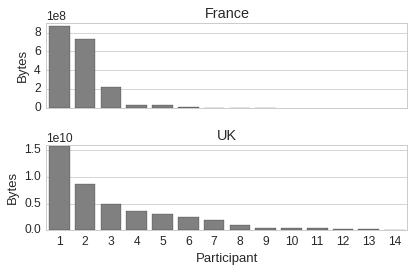

In [72]:
f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

sns.barplot(data=df1, x='x', y='bytes', ax=ax1, color=palette[0])
ax1.set_ylabel("Bytes")
#ax1.set_yscale('log')
ax1.set_yticks([y*1e8 for y in np.arange(0.0,10.0,2.0)])
#ax1.set_yticklabels([y*1e9 for y in np.arange(0.0,2.0,0.25)])
ax1.set_xlabel("")
ax1.set_title("France")

sns.barplot(data=df2, x='x', y='bytes', ax=ax2, color=palette[0])
ax2.set_ylabel("Bytes")
#ax2.set_yscale('log')
ax2.set_yticks([y*1e9 for y in np.arange(0.0,20.0,5.0)])
#ax2.set_yticklabels([y*1e1 for y in np.arange(0.0,2.0,0.25)])
ax2.set_xlabel("Participant")
ax2.set_title("UK")

plt.tight_layout()
f.savefig("../figs/dataset_traffic.eps")

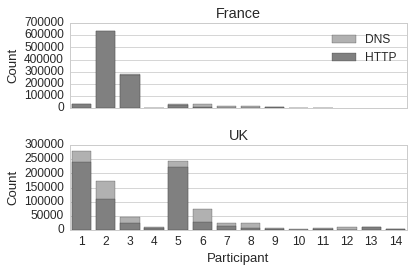

In [73]:
f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)

sns.barplot(data=df1, x='x', y='app', ax=ax1, color=palette[3], label='DNS')
sns.barplot(data=df1, x='x', y='http', ax=ax1, color=palette[0], label='HTTP')
ax1.set_ylabel("Count")
#ax1.set_yscale('log')
ax1.set_xlabel("")
ax1.set_title("France")
ax1.legend(loc='best')
    
sns.barplot(data=df2, x='x', y='app', ax=ax2, color=palette[3], label='DNS')
sns.barplot(data=df2, x='x', y='http', ax=ax2, color=palette[0], label='HTTP')
ax2.set_ylabel("Count")
#ax2.set_yscale('log')
ax2.set_xlabel("Participant")
ax2.set_title("UK")

plt.tight_layout()
f.savefig("../figs/dataset_appact.eps")

In [76]:
frselected = df1['uid'].head(6)
ukselected = df2['uid'].head(8)

devsperuser = {}
selecteddevs = []
for u in ses.query(User).filter(or_(User.id.in_(frselected),User.id.in_(ukselected))).all(): 
    udevs = [d.id for d in u.devices if not d.shared]
    devsperuser[u.id] = udevs 
    selecteddevs += udevs
    
print 'users', len(devsperuser), 'devices',len(selecteddevs)

# sorted order from above
sortedusers = [uid for uid in df['uid'] if uid in devsperuser]

totalbytes = ses.query(
        func.sum(DeviceAppTraffic.bytes_in)).filter(DeviceAppTraffic.devid.in_(selecteddevs)).scalar() + ses.query(
        func.sum(DeviceAppTraffic.bytes_out)).filter(DeviceAppTraffic.devid.in_(selecteddevs)).scalar()

totalhttpbytes = ses.query(
        func.sum(DeviceAppTraffic.bytes_in)).filter(
            DeviceAppTraffic.devid.in_(selecteddevs),
            or_(DeviceAppTraffic.dstport==80,DeviceAppTraffic.srcport==80)).scalar() + ses.query(
        func.sum(DeviceAppTraffic.bytes_out)).filter(
            DeviceAppTraffic.devid.in_(selecteddevs),
            or_(DeviceAppTraffic.dstport==80,DeviceAppTraffic.srcport==80)).scalar()


totalhttpsbytes = ses.query(
        func.sum(DeviceAppTraffic.bytes_in)).filter(
            DeviceAppTraffic.devid.in_(selecteddevs),
            or_(DeviceAppTraffic.dstport==443,DeviceAppTraffic.srcport==443)).scalar() + ses.query(
        func.sum(DeviceAppTraffic.bytes_out)).filter(
            DeviceAppTraffic.devid.in_(selecteddevs),
            or_(DeviceAppTraffic.dstport==443,DeviceAppTraffic.srcport==443)).scalar()

#print totalbytes,totalhttpbytes,totalhttpsbytes
print 'http traffic (%)',100.0*totalhttpbytes/totalbytes
print 'https traffic (%)',100.0*totalhttpsbytes/totalbytes
print 'http+https traffic (%)',100.0*(totalhttpsbytes+totalhttpbytes)/totalbytes

users 14 devices 27
http traffic (%) 28.3749635991
https traffic (%) 68.3376883216
http+https traffic (%) 96.7126519207


In [43]:
# construct top-x locations per traffic,app,user for each user

# uid => location => bytes
trafficperloc = {}

# uid => location => dns+http reqs
appperloc = {}

# uid => location => user reqs
userperloc = {}

ses = Session()
for uid in sortedusers:
    for devid in devsperuser[uid]:
        trafficperloc[devid] = defaultdict(long)
        appperloc[devid] = defaultdict(long)
        userperloc[devid] = defaultdict(long)
        
    q = ses.query(func.sum(DeviceAppTraffic.bytes_in+DeviceAppTraffic.bytes_out),
                     Location.name, Location.devid).join(Location,
                        and_(DeviceAppTraffic.devid==Location.devid,
                             DeviceAppTraffic.ts>=Location.entertime,
                             DeviceAppTraffic.ts<=Location.exittime)).filter(
                                Location.devid.in_(devsperuser[uid]),Location.overlap==False).group_by(Location.name, Location.devid)
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        trafficperloc[row[2]][loc] = row[0]

    q = ses.query(func.count(DnsReq.ts),
                  Location.name, Location.devid).join(Location,
                        and_(DnsReq.devid==Location.devid,
                             DnsReq.ts>=Location.entertime,
                             DnsReq.ts<=Location.exittime)).filter(
                                Location.devid.in_(devsperuser[uid]),Location.overlap==False).group_by(Location.name, Location.devid)
    
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        appperloc[row[2]][loc] += row[0]
        
    q = ses.query(func.count(HttpReq.ts),
                  Location.name, Location.devid).join(Location,
                        and_(HttpReq.devid==Location.devid,
                             HttpReq.ts>=Location.entertime,
                             HttpReq.ts<=Location.exittime)).filter(
                                Location.devid.in_(devsperuser[uid]),Location.overlap==False).group_by(Location.name, Location.devid)
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        appperloc[row[2]][loc] += row[0]

        
    q = ses.query(func.count(DnsReq.ts),
                  Location.name, Location.devid).join(Location,
                        and_(DnsReq.devid==Location.devid,
                             DnsReq.ts>=Location.entertime,
                             DnsReq.ts<=Location.exittime)).filter(
                                DnsReq.devid.in_(devsperuser[uid]),
                                DnsReq.user_req==True,
                                DnsReq.duplicate==False,
                                Location.overlap==False).group_by(Location.name, Location.devid)
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        userperloc[row[2]][loc] += row[0]
        
    q = ses.query(func.count(HttpReq.ts),
                  Location.name, Location.devid).join(Location,
                        and_(HttpReq.devid==Location.devid,
                             HttpReq.ts>=Location.entertime,
                             HttpReq.ts<=Location.exittime)).filter(
                                HttpReq.devid.in_(devsperuser[uid]),
                                HttpReq.user_url==True,
                                Location.overlap==False).group_by(Location.name, Location.devid)
    for row in q.all():
        loc = row[1]
        if (loc==None):
            loc = "default" 
        userperloc[row[2]][loc] += row[0]
ses.close()

In [44]:
ses = Session()

# get total traffic per device
devtotals = defaultdict(lambda : defaultdict(float))

q = ses.query(DeviceAppTraffic.devid, 
              func.sum(DeviceAppTraffic.bytes_in)+func.sum(DeviceAppTraffic.bytes_out)).filter(
                 DeviceAppTraffic.devid.in_(selecteddevs)).group_by(DeviceAppTraffic.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['bytes'] = row[1]*1.0

# DNS reqs (all) per device
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_all'] = row[1]*1.0

# filtered DNS reqs
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).filter(
                    DnsReq.user_req==True).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_filt1'] = row[1]*1.0
    
    
# filtered DNS reqs
q = ses.query(DnsReq.devid, 
              func.count(DnsReq.devid)).filter(DnsReq.devid.in_(selecteddevs)).filter(
                    DnsReq.user_req==True).filter(DnsReq.duplicate==False).group_by(
                        DnsReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['dns_filt2'] = row[1]*1.0
    
    
    
# HTTP reqs (all) per device
q = ses.query(HttpReq.devid, 
              func.count(HttpReq.devid)).filter(HttpReq.devid.in_(selecteddevs)).group_by(
                        HttpReq.devid)
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['http_all'] = row[1]*1.0

# filtered HTTP reqs
q = ses.query(HttpReq.devid, 
              func.count(HttpReq.devid)).filter(HttpReq.devid.in_(selecteddevs)).filter(
                    HttpReq.user_url==True).group_by(HttpReq.devid)              
for row in q.all():
    devid = str(row[0])
    devtotals[devid]['http_filt'] = row[1]*1.0    

In [75]:
# Build activity data for top-x locations
TOPX=3

data = defaultdict(list)
for devid in selecteddevs:
    allbytes = devtotals[str(devid)]['bytes']
    allappbytes = devtotals[str(devid)]['dns_all']+devtotals[str(devid)]['http_all']
    alluserbytes = devtotals[str(devid)]['dns_filt2']+devtotals[str(devid)]['http_filt']
    if (allbytes == 0):
        continue
        
    data['devid'].append(devid)
    data['bytes'].append(allbytes)

    # if we've only ever seen a single location
    # from this device => assume stationary and flag all from that loc
    locs = ses.query(Location.name, func.count(Location.id)).filter(
            Location.devid==devid).group_by(Location.name).all()
    
    # top three traffic 
    if (len(locs)>1):    
        # been in more than one loc
        
        for i,loc in enumerate(sorted(trafficperloc[devid].keys(), key=lambda x : trafficperloc[devid][x], reverse=True)[:TOPX]):
            data['tloc%d'%(i+1)].append(100.0 * (trafficperloc[devid][loc]*1.0/allbytes))
        i = min(len(trafficperloc[devid]),3)
        while (i<3):
            data['tloc%d'%(i+1)].append(0.0)
            i += 1

        bc = 0.0
        for i,loc in enumerate(sorted(trafficperloc[devid].keys(), key=lambda x : trafficperloc[devid][x], reverse=True)[TOPX:]):
            bc += trafficperloc[devid][loc]*1.0
        data['tloco'].append(100.0*(bc/allbytes))

        # top three app
        for i,loc in enumerate(sorted(appperloc[devid].keys(), key=lambda x : appperloc[devid][x], reverse=True)[:TOPX]):
            data['aloc%d'%(i+1)].append(100.0 * (appperloc[devid][loc]*1.0/allappbytes))
        i = min(len(appperloc[devid]),3)
        while (i<3):
            data['aloc%d'%(i+1)].append(0.0)
            i += 1

        bc = 0.0
        for i,loc in enumerate(sorted(appperloc[devid].keys(), key=lambda x : appperloc[devid][x], reverse=True)[TOPX:]):
            bc += appperloc[devid][loc]*1.0
        data['aloco'].append(100.0*(bc/allappbytes))
            
            
        # top three user
        for i,loc in enumerate(sorted(userperloc[devid].keys(), key=lambda x : userperloc[devid][x], reverse=True)[:TOPX]):
            data['uloc%d'%(i+1)].append(100.0 * (userperloc[devid][loc]*1.0/alluserbytes))
        i = min(len(userperloc[devid]),3)
        while (i<3):
            data['uloc%d'%(i+1)].append(0.0)
            i += 1
        
        bc = 0.0
        for i,loc in enumerate(sorted(userperloc[devid].keys(), key=lambda x : userperloc[devid][x], reverse=True)[TOPX:]):
            bc += userperloc[devid][loc]*1.0
        data['uloco'].append(100.0*(bc/alluserbytes))
        
    elif (len(locs)==1):
        # single location device
        
        data['tloc1'].append(100.0)
        data['tloc2'].append(0.0)
        data['tloc3'].append(0.0)
        data['tloco'].append(0.0)
        
        data['aloc1'].append(100.0)
        data['aloc2'].append(0.0)
        data['aloc3'].append(0.0)
        data['aloco'].append(0.0)

        data['uloc1'].append(100.0)
        data['uloc2'].append(0.0)
        data['uloc3'].append(0.0)
        data['uloco'].append(0.0)
        
    else:
        # no loc
        
        data['tloco'].append(0.0)
        data['tloc1'].append(0.0)
        data['tloc2'].append(0.0)
        data['tloc3'].append(0.0)

        data['aloco'].append(0.0)
        data['aloc1'].append(0.0)
        data['aloc2'].append(0.0)
        data['aloc3'].append(0.0)

        data['uloco'].append(0.0)
        data['uloc1'].append(0.0)
        data['uloc2'].append(0.0)
        data['uloc3'].append(0.0)
        
#for k in data:
#    print k,len(data[k])
        
ldf = pd.DataFrame(data)

# stacked fractions
ldf['tloc2st'] = ldf['tloc1']+ldf['tloc2']
ldf['tloc3st'] = ldf['tloc1']+ldf['tloc2']+ldf['tloc3']
ldf['tlocost'] = ldf['tloc1']+ldf['tloc2']+ldf['tloc3']+ldf['tloco']
ldf['tlocna'] = 100.0

ldf['aloc2st'] = ldf['aloc1']+ldf['aloc2']
ldf['aloc3st'] = ldf['aloc1']+ldf['aloc2']+ldf['aloc3']
ldf['alocost'] = ldf['aloc1']+ldf['aloc2']+ldf['aloc3']+ldf['aloco']
ldf['alocna'] = 100.0

ldf['uloc2st'] = ldf['uloc1']+ldf['uloc2']
ldf['uloc3st'] = ldf['uloc1']+ldf['uloc2']+ldf['uloc3']
ldf['ulocost'] = ldf['uloc1']+ldf['uloc2']+ldf['uloc3']+ldf['uloco']
ldf['ulocna'] = 100.0

ses.close()

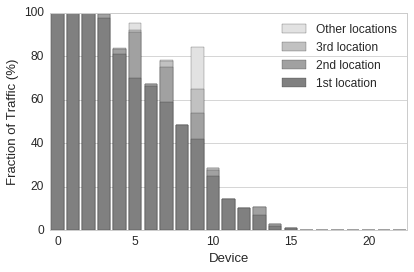

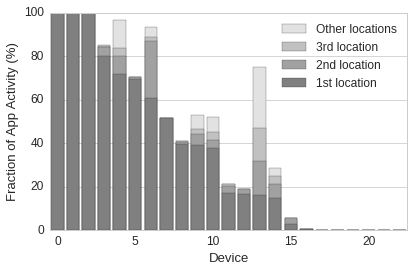

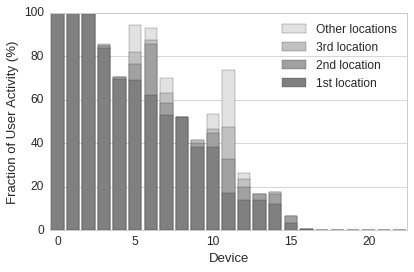

In [77]:
# For section4: Device use vs locations
f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

ldf = ldf.sort_values('tloc1', ascending=False)
ldf['rank'] = list(range(len(data['devid'])))

sns.barplot(data=ldf, x='rank', y='tlocost', ax=ax1, orient='v', color=palette[6], label="Other locations")
sns.barplot(data=ldf, x='rank', y='tloc3st', ax=ax1, orient='v', color=palette[4], label="3rd location")
sns.barplot(data=ldf, x='rank', y='tloc2st', ax=ax1, orient='v', color=palette[2], label="2nd location")
sns.barplot(data=ldf, x='rank', y='tloc1', ax=ax1, orient='v', color=palette[0], label="1st location")

ax1.set_ylabel("Fraction of Traffic (%)")
ax1.set_xticks(range(0,len(data['devid']),5))
ax1.set_xticklabels(range(0,len(data['devid']),5))
ax1.set_xlabel("Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/corr_device_location_bytes.eps")              

f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

ldf = ldf.sort_values('aloc1', ascending=False)
ldf['rank'] = list(range(len(data['devid'])))

sns.barplot(data=ldf, x='rank', y='alocost', ax=ax1, orient='v', color=palette[6], label="Other locations")
sns.barplot(data=ldf, x='rank', y='aloc3st', ax=ax1, orient='v', color=palette[4], label="3rd location")
sns.barplot(data=ldf, x='rank', y='aloc2st', ax=ax1, orient='v', color=palette[2], label="2nd location")
sns.barplot(data=ldf, x='rank', y='aloc1', ax=ax1, orient='v', color=palette[0], label="1st location")

ax1.set_ylabel("Fraction of App Activity (%)")
ax1.set_xticks(range(0,len(data['devid']),5))
ax1.set_xticklabels(range(0,len(data['devid']),5))
ax1.set_xlabel("Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/corr_device_location_app.eps")              


f, ax1 = plt.subplots(1, 1, figsize=(6, 4))

ldf = ldf.sort_values('uloc1', ascending=False)
ldf['rank'] = list(range(len(data['devid'])))

sns.barplot(data=ldf, x='rank', y='ulocost', ax=ax1, orient='v', color=palette[6], label="Other locations")
sns.barplot(data=ldf, x='rank', y='uloc3st', ax=ax1, orient='v', color=palette[4], label="3rd location")
sns.barplot(data=ldf, x='rank', y='uloc2st', ax=ax1, orient='v', color=palette[2], label="2nd location")
sns.barplot(data=ldf, x='rank', y='uloc1', ax=ax1, orient='v', color=palette[0], label="1st location")

ax1.set_ylabel("Fraction of User Activity (%)")
ax1.set_xticks(range(0,len(data['devid']),5))
ax1.set_xticklabels(range(0,len(data['devid']),5))
ax1.set_xlabel("Device")
ax1.legend(loc='best')

plt.tight_layout()
f.savefig("../figs/corr_device_location_user.eps")              

In [47]:
# collect heatmap data for device use to time-of-day
ses = Session()

# minutes
BINSIZE=60
        
trafficdata = []
appdata = []
userdata = []

yticks = []
yidx = 0

ignoreddevs = {}

for uid in sortedusers:
    yticks.append(yidx)
    
    for devid in devsperuser[uid]:
        alltotal = 0.0
        alldays = {}
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            alldays[k] = 0.0

        q = ses.query(DeviceAppTraffic.ts, 
                      DeviceAppTraffic.bytes_in+DeviceAppTraffic.bytes_out).filter(
                        DeviceAppTraffic.devid==devid)

        for (ts,bytes) in q.all():
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE
            alldays[binidx] += bytes
            alltotal += bytes

        if (alltotal==0):
            ignoreddevs[devid] = True
            continue
        yidx += 1
            
        # to % of bytes
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            if (alltotal>0):
                alldays[k] = 100.0*(alldays[k]*1.0/alltotal)

        trafficdata.append(alldays.values())

        if (devid in ignoreddevs):
            continue
            
        alltotal = 0.0
        alldays = {}
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            alldays[k] = 0.0
        
        q = ses.query(HttpReq.ts).filter(HttpReq.devid==devid)    
        for row in q.all():
            ts = row[0]
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE
            alldays[binidx] += 1
            alltotal += 1

        q = ses.query(DnsReq.ts).filter(DnsReq.devid==devid) 
        for row in q.all():
            ts = row[0]
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE
            alldays[binidx] += 1
            alltotal += 1
                
        # to % of bytes
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            if (alltotal>0):
                alldays[k] = 100.0*(alldays[k]*1.0/alltotal)

        appdata.append(alldays.values())
        
        alltotal = 0.0
        alldays = {}
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            alldays[k] = 0.0
        
        q = ses.query(HttpReq.ts).filter(
                        HttpReq.devid==devid).filter(
                        HttpReq.user_url==True)    
        for row in q.all():
            ts = row[0]
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE
            alldays[binidx] += 1
            alltotal += 1

        q = ses.query(DnsReq.ts).filter(
                        DnsReq.devid==devid).filter(
                        DnsReq.user_req==True, DnsReq.duplicate==False) 
        for row in q.all():
            ts = row[0]
            timeofday = ts.hour*60 + ts.minute
            binidx = timeofday/BINSIZE
            alldays[binidx] += 1
            alltotal += 1
                
        # to % of bytes
        for k in range(0,24*60,BINSIZE):
            k = k/BINSIZE
            if (alltotal>0):
                alldays[k] = 100.0*(alldays[k]*1.0/alltotal)

        userdata.append(alldays.values())
        
ses.close()

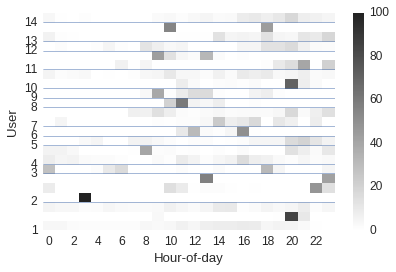

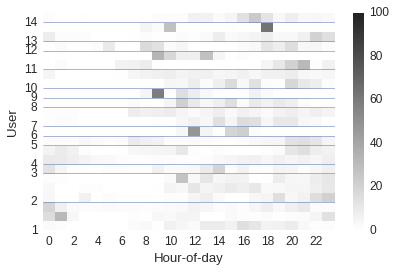

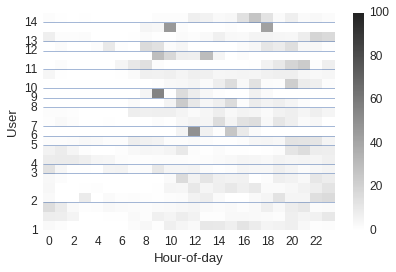

In [79]:
cmap = sns.dark_palette("#ffffff", as_cmap=True, reverse=True)

def doplot(data,fname=None):
    f, ax = plt.subplots(1, 1, figsize=(6, 4))        
    ax = sns.heatmap(data, 
                     cmap=cmap,
                     vmin=0, 
                     vmax=100.0, 
                     yticklabels=False,
                     xticklabels=2)
    
    ax.set_xlabel("Hour-of-day")
    
    ax.set_ylabel("User")
    ax.yaxis.set_ticks(yticks)
    ax.set_yticklabels([i+1 for i in range(len(yticks))])
    for ymaj in ax.yaxis.get_majorticklocs():
        ax.axhline(y=ymaj,ls='-',lw=0.5, color='b')
        
    plt.tight_layout()
    plt.show()    
    if (fname!=None):
        f.savefig(fname)

doplot(trafficdata, "../figs/corr_traffic_timeofday.eps")
doplot(appdata, "../figs/corr_app_timeofday.eps")
doplot(userdata, "../figs/corr_user_timeofday.eps")

In [49]:
# get unique ips, dns+http domains, user dns+http domains / user / device
data = defaultdict(list)

ses = Session()

for rank,uid in enumerate(sortedusers):
    uniqueips = defaultdict(set)
    uniqueapps = defaultdict(set)
    uniqueuser = defaultdict(set)    
    for devid in devsperuser[uid]:
        q = ses.query(distinct(DeviceAppTraffic.dstip)).filter(DeviceAppTraffic.devid==devid)
        uniqueips[devid] = set([r[0] for r in q.all()])

        q = ses.query(distinct(DnsReq.query)).filter(DnsReq.devid==devid)
        uniqueapps[devid] = set([r[0] for r in q.all()])

        q = ses.query(distinct(HttpReq.req_url_host)).filter(HttpReq.devid==devid)
        uniqueapps[devid] = uniqueapps[devid] | set([r[0] for r in q.all()])

        q = ses.query(distinct(DnsReq.query)).filter(
                DnsReq.devid==devid, DnsReq.user_req==True, DnsReq.duplicate==False)
        uniqueuser[devid] = set([r[0] for r in q.all()])

        q = ses.query(distinct(HttpReq.req_url_host)).filter(
                HttpReq.devid==devid, HttpReq.user_url==True)
        uniqueuser[devid] = uniqueuser[devid] | set([r[0] for r in q.all()])
        
    data['rank'].append(rank)
    data['devs'].append(len(devsperuser[uid]))
    
    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueips[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueips[devid2])
        c += len(s)
    data['ip'].append(100.0*(c*1.0/len(fulls)))
    data['ipcount'].append(len(fulls))

    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueapps[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueapps[devid2])
        c += len(s)
    data['app'].append(100.0*(c*1.0/len(fulls)))    
    data['appcount'].append(len(fulls))
    
    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueuser[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueuser[devid2])
        c += len(s)
    data['user'].append(100.0*(c*1.0/len(fulls)))    
    data['usercount'].append(len(fulls))
    
cdf = pd.DataFrame(data)
    
ses.close()

In [88]:
# get unique ips, dns+http domains, user dns+http domains / user / device
data = defaultdict(list)

ses = Session()

def toplevelset(domains):
    """Filter domains to include only top-level info."""
    res = []
    for d in domains:
        tmp = d.split('.')
        if (d.endswith('co.uk') and len(tmp)>3):
            res.append("%s.%s.%s"%(tmp[-3],tmp[-2],tmp[-2]))
        elif (len(tmp)>2):
            res.append("%s.%s"%(tmp[-2],tmp[-2]))
        else:
            res.append(d)
    return set(res)

for rank,uid in enumerate(sortedusers):
    if (len(devsperuser[uid])==1 or len([devid for devid in devsperuser[uid] if devid in ignoreddevs])>0):
        continue
        
    uniqueips = defaultdict(set)
    uniqueapps = defaultdict(set)
    uniqueuser = defaultdict(set)    
    for devid in devsperuser[uid]:
        q = ses.query(distinct(DeviceAppTraffic.dstip)).filter(DeviceAppTraffic.devid==devid)
        uniqueips[devid] = set([r[0] for r in q.all()])

        q = ses.query(DnsReq.query, func.count(DnsReq.ts)).filter(DnsReq.devid==devid).group_by(DnsReq.query)
        uniqueapps[devid] = toplevelset([r[0] for r in q.all() if r[1]>1])

        q = ses.query(HttpReq.req_url_host, func.count(HttpReq.ts)).filter(
            HttpReq.devid==devid).group_by(HttpReq.req_url_host)
        uniqueapps[devid] = uniqueapps[devid] | toplevelset([r[0] for r in q.all() if r[1]>1])

        q = ses.query(DnsReq.query, func.count(DnsReq.ts)).filter(
                DnsReq.devid==devid, DnsReq.user_req==True, DnsReq.duplicate==False).group_by(DnsReq.query)
        uniqueuser[devid] = toplevelset([r[0] for r in q.all() if r[1]>1])

        q = ses.query(HttpReq.req_url_host, func.count(HttpReq.ts)).filter(
                HttpReq.devid==devid, HttpReq.user_url==True).group_by(HttpReq.req_url_host)
        uniqueuser[devid] = uniqueuser[devid] | toplevelset([r[0] for r in q.all() if r[1]>1])
        
    data['rank'].append(rank)
    data['devs'].append(len(devsperuser[uid]))
    
    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueips[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueips[devid2])
        c += len(s)
    data['ip'].append(100.0*(c*1.0/len(fulls)))
    data['ipcount'].append(len(fulls))

    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueapps[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueapps[devid2])
        c += len(s)
    data['app'].append(100.0*(c*1.0/len(fulls)))    
    data['appcount'].append(len(fulls))
    
    c = 0
    fulls = set([])
    for devid in devsperuser[uid]:
        # count ips unique to this dev
        s = uniqueuser[devid]
        fulls = fulls | s
        for devid2 in devsperuser[uid]:
            if (devid==devid2):
                continue
            s = s - (s&uniqueuser[devid2])
        c += len(s)
    data['user'].append(100.0*(c*1.0/len(fulls)))    
    data['usercount'].append(len(fulls))
    
cdf = pd.DataFrame(data)
    
ses.close()

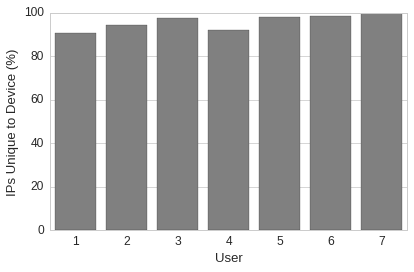

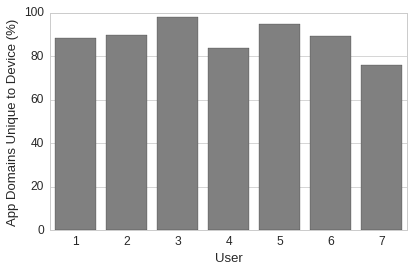

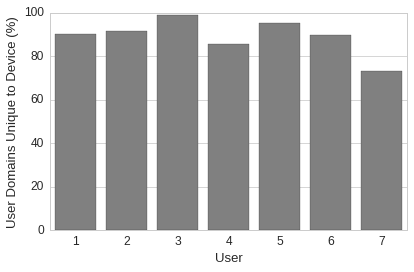

In [89]:
#    correlation of visits to sites on multiple devices
# => % of ips, app, user visited on single device / per user (100 for 1 dev users, for others ?)

#f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
f, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=True)

cdf = cdf.sort_values('ipcount', ascending=False)
cdf['rank'] = list(range(len(data['rank'])))

#sns.barplot(data=cdf, x='rank', y='ipcount', ax=ax1, orient='v', color=palette[0])
#ax1.set_ylabel("Unique")
#ax1.set_xlabel("")

sns.barplot(data=cdf, x='rank', y='ip', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("IPs Unique to Device (%)")
ax1.set_xlabel("User")
ax1.set_xticklabels([i+1 for i in range(len(data['rank']))])

plt.tight_layout()
f.savefig("../figs/corr_device_traffic.eps")   


#f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
f, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=True)

cdf = cdf.sort_values('appcount', ascending=False)
cdf['rank'] = list(range(len(data['rank'])))


#sns.barplot(data=cdf, x='rank', y='appcount', ax=ax1, orient='v', color=palette[0])
#ax1.set_ylabel("Unique")
#ax1.set_xlabel("")

sns.barplot(data=cdf, x='rank', y='app', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("App Domains Unique to Device (%)")
ax1.set_xlabel("User")
ax1.set_xticklabels([i+1 for i in range(len(data['rank']))])

plt.tight_layout()
f.savefig("../figs/corr_device_app.eps")   

#f, ((ax1),(ax2)) = plt.subplots(2, 1, figsize=(6, 4), sharex=True)
f, ax1 = plt.subplots(1, 1, figsize=(6, 4), sharex=True)

cdf = cdf.sort_values('usercount', ascending=False)
cdf['rank'] = list(range(len(data['rank'])))

#sns.barplot(data=cdf, x='rank', y='usercount', ax=ax1, orient='v', color=palette[0])
#ax1.set_ylabel("Unique")
#ax1.set_xlabel("")

sns.barplot(data=cdf, x='rank', y='user', ax=ax1, orient='v', color=palette[0])
ax1.set_ylabel("User Domains Unique to Device (%)")
ax1.set_xlabel("User")
ax1.set_xticklabels([i+1 for i in range(len(data['rank']))])

plt.tight_layout()
f.savefig("../figs/corr_device_user.eps")   
